In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from glob import glob

import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings

warnings.filterwarnings("ignore")

C:\Users\sande\anaconda3\envs\gpuTF\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 4
NUM_CLASSES = 3
DATA_DIR = "./DataSet/Training/"
NUM_TRAIN_IMAGES = 7000

train_images = sorted(glob(os.path.join(DATA_DIR, "im/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "gt_categorized/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "im/*")))[NUM_TRAIN_IMAGES:]
val_masks = sorted(glob(os.path.join(DATA_DIR, "gt_categorized/*")))[NUM_TRAIN_IMAGES:]


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_bmp(image, channels=0)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_bmp(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image/255
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 224, 224, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 224, 224, 1), dtype=tf.float32, name=None))>


In [3]:
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same",use_bias=False):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same", use_bias=use_bias, kernel_initializer=keras.initializers.HeNormal())(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",)(x)
    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [4]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=model_input)
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]), interpolation="bilinear",)(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(size=(image_size // x.shape[1], image_size // x.shape[2]),interpolation="bilinear",)(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

model = DeeplabV3Plus(image_size=224, num_classes=3)

In [5]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=loss, metrics=["accuracy"])
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
1750/1750 [==============================] - 2330s 1s/step - loss: 0.5455 - accuracy: 0.7805 - val_loss: 0.4948 - val_accuracy: 0.8381
Epoch 2/5
1750/1750 [==============================] - 2363s 1s/step - loss: 0.2594 - accuracy: 0.9053 - val_loss: 0.2654 - val_accuracy: 0.9045
Epoch 3/5
1750/1750 [==============================] - 2407s 1s/step - loss: 0.1832 - accuracy: 0.9349 - val_loss: 0.6112 - val_accuracy: 0.8558
Epoch 4/5
1750/1750 [==============================] - 2281s 1s/step - loss: 0.1382 - accuracy: 0.9512 - val_loss: 0.3295 - val_accuracy: 0.9017
Epoch 5/5
1750/1750 [==============================] - 2380s 1s/step - loss: 0.1054 - accuracy: 0.9627 - val_loss: 0.0898 - val_accuracy: 0.9680


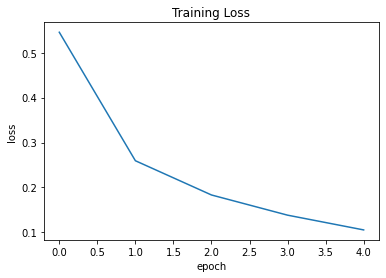

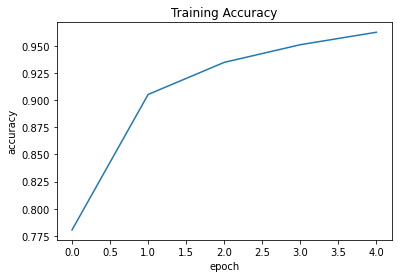

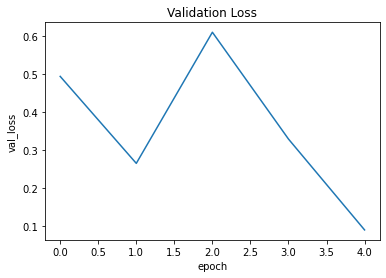

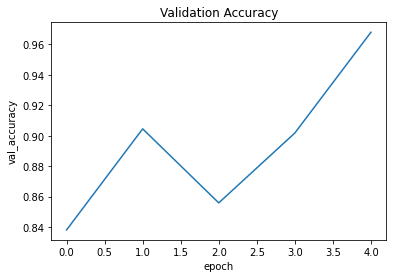

In [6]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [7]:
model.save("DeepLabV3Plus.h5")